# **PyPSA-Eur Curtailment Emulator**

This notebook first calculates the parameters based on existing PyPSA-Eur scenarios, which we then use afterwards to evaluate the skill of the emulator at different combinations of wind, solar, short-duration and long-duration electricity storage. 

In [1]:
from scripts.pypsa_curtailment_emulator import *
from scripts.curtailment_equations import *
from scripts.plotting import mesh_color_2
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
%load_ext autoreload
%autoreload 2

fs = 15
plt.style.use('seaborn-ticks')
plt.rcParams['axes.labelsize'] = fs
plt.rcParams['xtick.labelsize'] = fs
plt.rcParams['ytick.labelsize'] = fs
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['hatch.color'] = "lightgrey"

Explore which scenarios are available:

In [2]:
RDIR = "calculated_metrics" # directory with the results of the PyPSA runs (.csv files)

scens_list = [x for x in os.listdir(RDIR + '/') if x.startswith("new_")]
print(scens_list)

['new_base', 'new_base_co2_lim', 'new_flipped_merit_order', 'new_full_sectors', 'new_full_sectors_SDES', 'new_full_sectors_SDES_LDES', 'new_H2_demand', 'new_H2_demand_co2_lim', 'new_heating_demand', 'new_heating_demand_co2_lim', 'new_LDES', 'new_LDES_co2_lim', 'new_SDES', 'new_SDES_co2_lim', 'new_SDES_LDES', 'new_SDES_LDES_co2_lim', 'new_transmission', 'new_transmission_co2_lim', 'new_transmission_SDES', 'new_transmission_SDES_co2_lim', 'new_transmission_SDES_LDES', 'new_transmission_SDES_LDES_co2_lim', 'new_transport', 'new_transport_co2_lim']


The suffix "co2_lim" in the scenario name indicates that a Europe-aggregate CO2-emissions limit of 5% relative to 1990-levels has been applied. If the suffix is not included, no CO2-emissions limit has been defined.

Group scenarios by category (e.g., collecting all scenarios that allow for storage capacity expansion in the same list):

In [3]:
scens_series = pd.Series(scens_list)

#¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ power system ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

# scenarios that allow for transmission expansion:
scens_w_transmission = scens_series.loc[scens_series.str.contains("transmission")].to_list()

# scenarios that allow for long-duration storage deployment: 
scens_w_ldes = scens_series.loc[scens_series.str.contains("LDES")].to_list()

# scenarios that allow for short-duration storage deployment:
scens_w_sdes = scens_series.loc[scens_series.str.contains("SDES")].to_list()

#¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤ sector-coupling ¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤¤

# scenarios that allow for sector-coupling with the heating sector:
scens_w_heating = scens_series.loc[scens_series.str.contains("heating")].to_list()

# scenarios that allow for sector-coupling with the land transport sector:
scens_w_transport = scens_series.loc[scens_series.str.contains("transport")].to_list()

# scenarios that allow for sector-coupling with the industry sector:
scens_w_industry = scens_series.loc[scens_series.str.contains("industry")].to_list()

print("scenarios with SDES: ", scens_w_sdes)
print("scenarios with LDES: ", scens_w_ldes)
print("scenarios with transmission: ", scens_w_transmission)

scenarios with SDES:  ['new_full_sectors_SDES', 'new_full_sectors_SDES_LDES', 'new_SDES', 'new_SDES_co2_lim', 'new_SDES_LDES', 'new_SDES_LDES_co2_lim', 'new_transmission_SDES', 'new_transmission_SDES_co2_lim', 'new_transmission_SDES_LDES', 'new_transmission_SDES_LDES_co2_lim']
scenarios with LDES:  ['new_full_sectors_SDES_LDES', 'new_LDES', 'new_LDES_co2_lim', 'new_SDES_LDES', 'new_SDES_LDES_co2_lim', 'new_transmission_SDES_LDES', 'new_transmission_SDES_LDES_co2_lim']
scenarios with transmission:  ['new_transmission', 'new_transmission_co2_lim', 'new_transmission_SDES', 'new_transmission_SDES_co2_lim', 'new_transmission_SDES_LDES', 'new_transmission_SDES_LDES_co2_lim']


# **Creating the PyPSA Curtailment Emulator**

The Excel file `pypsa_curtailment_emulator.xlsx` contains the equations representing the renewable curtailment at a given share of wind, solar, battery, and long-duration energy storage. 

First, we will update the parameters used in the equations. We can do this, making the parameterization dependent on a scenario with or without a CO2 emissions limit (*"new_base"* and *"new_base_co2_lim"*).

In [4]:
file_path = 'Excel_version/PyPSA_curtailment_emulator.xlsx' # location of pypsa emulator excel file
base_case = "new_base_co2_lim" # name of base curtailment scenario
SDES_case = "new_SDES_co2_lim" # name of the scenario representing the curtailment impact of SDES
LDES_case = "new_SDES_LDES_co2_lim" # name of the scenario representing the curtailment impact of LDES
transmission_case = 'new_transmission_SDES_LDES_co2_lim' # electricity transmission expansion scenario

# energy efficiencies assumed in PyPSA-Eur:
efficiencies = {"LDES":0.48,
                "SDES":0.9,
                "transmission":1,
                } 

tech_labels = {"LDES":"absolute dispatch", # variable name as it is used in the calculated metrics
                "SDES":"absolute dispatch", # variable name as it is used in the calculated metrics
                "transmission":"volume",# variable name as it is used in the calculated metrics
                }
                
scenarios = {"base":base_case,

             "LDES":
                {"wind":[base_case,SDES_case,LDES_case],
                 "solar":[SDES_case,SDES_case,LDES_case]},
                 
             "SDES":
                {"solar":[base_case,base_case,SDES_case],
                 "wind":[base_case,base_case,SDES_case]},

            "transmission":
                {"solar":[base_case,LDES_case,transmission_case],
                 "wind":[base_case,LDES_case,transmission_case]},

            #  "heating":
            #     {"wind":[],
            #      "solar":[]},
            
            #  "transport":
            #     {"wind":[],
            #      "solar":[]},

            #  "industry":
            #     {"wind":[],
            #      "solar":[]}

                }

Update parameters according to the specified scenarios (if not needed, set the *update_parameters* to False which keeps the existing parameters):


In [5]:
update_parameters = True
continuous_axis = "both" # "primary", "secondary", or "both"
if update_parameters:
    create_emulator(scenarios,
                    RDIR,
                    file_path,
                    efficiencies,
                    tech_labels,
                    continuous_axis,
                    update_excel_file=False, # if True, updates the excel file with the results of the PyPSA runs
                                            # Note that the Excel file only updates parameters of wind, solar, LDES, and SDES.
                                            # Furthermore, this is only possible with the continuous_axis set to either "primary"
                                            # or "secondary".
                    ) 

Launching parameterization using both axis as continuous resource...
Wind curtailment successfully parameterized! Proceeding to solar curtailment...
Solar curtailment successfully parameterized! Proceeding to technology term...
LDES impact on wind curtailment successfully parameterized!
SDES impact on wind curtailment successfully parameterized!
transmission impact on wind curtailment successfully parameterized!
LDES impact on solar curtailment successfully parameterized!
SDES impact on solar curtailment successfully parameterized!
transmission impact on solar curtailment successfully parameterized!
Parameterization done!


# **Testing the PyPSA Curtailment Emulator**

In [6]:
def run_pypsa_emulator_python(renewable,demand, primary_resource, secondary_resource, act_techs,continuous_axis, scaling_p=1,scaling_s=0):
    primary_term_sum, secondary_term_sum = include_base_curtailment(renewable,primary_resource,secondary_resource,demand,continuous_axis,scaling_p,scaling_s)
    tech_term_sum = include_tech_term(act_techs.keys(),act_techs,renewable,primary_resource,secondary_resource,demand)
        
    total_curtailment_d = primary_term_sum + secondary_term_sum + sum(tech_term_sum.values()) # percentage of demand
    
    # add lower bound to total_curtailment_d
    if primary_resource > 0 and type(total_curtailment_d) != int:
        total_curtailment_d[total_curtailment_d < 0] = 0
        total_curtailment_r = total_curtailment_d/primary_resource*100 # percentage of resources
        
        total_curtailment_d = total_curtailment_d.item()
        total_curtailment_r = total_curtailment_r.item()
    
    else:
        total_curtailment_r = 0
        
    return total_curtailment_d, total_curtailment_r

In [7]:
def test_pypsa_emulator_python(primary_res,
                               secondary_res,
                               renewable,
                               demand, 
                               act_techs, 
                               continuous_axis,
                               scaling_p=1,
                               scaling_s=0):
    
    print("Evaluating " + renewable + " curtailment, using " + continuous_axis + " resource as the continuous axis...")
    curtailment_d = {}
    curtailment_r = {}
    for primary_resource in primary_res:
        for secondary_resource in secondary_res:
            if primary_resource + secondary_resource <= 130:
                curt_d,curt_r = run_pypsa_emulator_python(renewable,demand, primary_resource, secondary_resource, act_techs, continuous_axis, scaling_p,scaling_s)
                curtailment_d[secondary_resource,primary_resource] = curt_d
                curtailment_r[secondary_resource,primary_resource] = curt_r

    return curtailment_d, curtailment_r

In [8]:
def run_pypsa_emulator(wind_res,solar_res,techs,curtailment_type,results_path,demand, scaling_p=1, scaling_s=0, overwrite=False):
    N = len(wind_res)*len(solar_res) # number of wind-solar combinations
    scenario_name = "".join([list(techs.keys())[i] + "_" + str(list(techs.values())[i]) + "_" for i in range(len(techs))])
    filename_wind = "wind_curtailment_N" + str(N) + "_" + scenario_name + curtailment_type + ".csv"
    filename_solar = "solar_curtailment_N" + str(N) + "_" +scenario_name + curtailment_type + ".csv"

    file_exist = os.path.isfile(results_path + filename_wind) and os.path.isfile(results_path + filename_solar)
    
    if file_exist and overwrite == False:
        print("Files exist. Reading .csv files...")
        wind_curtailment_series = pd.read_csv(results_path + filename_wind, index_col=[0,1])["0"]
        solar_curtailment_series = pd.read_csv(results_path + filename_solar, index_col=[0,1])["0"]
        print("Curtailment estimates were successfully read.")
    
    else:
        if file_exist:
            print("Files exist. Overwriting .csv files...")
        else:
            print("Files do not exist. Creating new .csv files...")

        wind_curtailment_d, wind_curtailment_r = test_pypsa_emulator_python(wind_res,solar_res,"wind",demand, techs, continuous_axis, scaling_p,scaling_s)
        solar_curtailment_d, solar_curtailment_r = test_pypsa_emulator_python(solar_res,wind_res,"solar",demand, techs, continuous_axis, scaling_p,scaling_s)
        
        if curtailment_type == "demand":
            wind_curtailment_series = pd.Series(wind_curtailment_d).sort_index()
            solar_curtailment_series = pd.Series(solar_curtailment_d).reorder_levels([1,0]).sort_index()
        
        elif curtailment_type == "resources":
            wind_curtailment_series = pd.Series(wind_curtailment_r).sort_index()
            solar_curtailment_series = pd.Series(solar_curtailment_r).reorder_levels([1,0]).sort_index()

        if overwrite == True:
            wind_curtailment_series.to_csv("results/" + filename_wind)
            solar_curtailment_series.to_csv("results/" + filename_solar)

        print("Curtailment estimation complete.")

        return wind_curtailment_series, solar_curtailment_series, scenario_name

# Scenario definition

Define the scenario for the estimation of the curtialment based on the renewable penetration of wind energy and solar PV, as well as the level of storage dispatch from short-duration (SDES) and long-duration energy storage (LDES). 

Note that the current version of this repository uses an Excel sheet which might lead to long computation time since it reads and writes to the file in every iteration.

In [9]:
results_path = "results/" # directory at which curtailment estimates will be stored
curtailment_type = "demand" # "demand" or "resources
overwrite = True # Whether existing files should be overwritten (True) or not (False)

demand = 100 # electricity demand on transmission and distribution level
step = 10
wind_res = np.arange(step,100,step) # wind resources (in percentage of demand)
solar_res = np.arange(step,100,step) # solar resources (in percentage of demand)
N = len(wind_res)*len(solar_res) # number of wind-solar combinations
techs = {"ldes":0, # activity of long-duration storage (in percentage of demand)
        "sdes":0, # activity of short-duration storage (in percentage of demand)
        "transmission":0, # transmission expansion (in percentage of existing transmission volume)
        }

# scaling (weighting) factors of the two interpolants
scaling_p = 1 # weighting of the interpolant along the primary axis
scaling_s = 1 - scaling_p # weighting of the interpolant along the secondary axis

wind_curtailment_series, solar_curtailment_series, scenario_name = run_pypsa_emulator(wind_res,solar_res,techs,curtailment_type,results_path,demand, scaling_p, scaling_s, overwrite=False)
# Here, 6.4 and 18.7 for LDES and SDES correspond to the optimum values in the PyPSA-Eur scenario 
# with a 50%-50% wind and solar share.  

# features from sector-coupling (to be added):
# heat_demand = 0 # heat demand (in percentage of demand)
# h2_demand = 0 # hydrogen demand (in percentage of demand)
# EVs = 0 # electricity demand of EVs (in percentage of demand)
# heat_pump = 0 # heat pump activity (in percentage of demand)

Files do not exist. Creating new .csv files...
Evaluating wind curtailment, using both resource as the continuous axis...
Evaluating solar curtailment, using both resource as the continuous axis...
Curtailment estimation complete.


# Visualize the estimated curtailment levels from the emulator

In [10]:
color_max_value = 70

## For the case with zero storage and no transmission expansion

Wind:

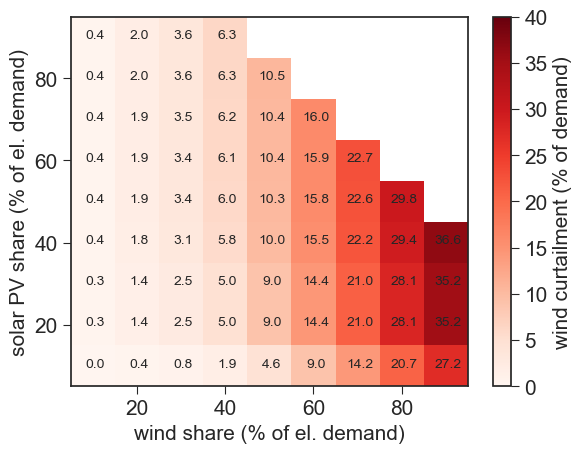

In [11]:
fig1, ax1, df1 = color_plot_2D(wind_curtailment_series, 
                               renewable = "wind", 
                               vmax = 40,
                               cbar_label=curtailment_type,
                               write_values=True)

# mask dataframe such that only values below a certain threshold are shown
df_m = mask_df(df1,threshold=0)
ax1.pcolor(df1.columns,df1.index,df_m, hatch='/', alpha=0.)

fig1.savefig("figures/wind/" + "wind_curtailment_N" + str(N) + "_" + scenario_name + "_" + curtailment_type + "_primary.png",
                bbox_inches="tight",
                dpi=300)

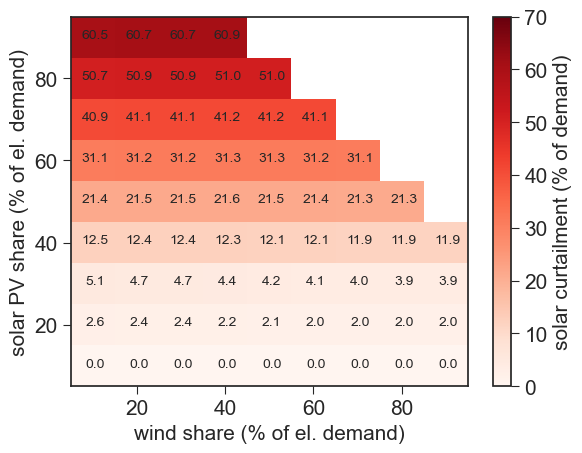

In [12]:
fig1, ax1, df1 = color_plot_2D(solar_curtailment_series, 
                               renewable = "solar", 
                               vmax = color_max_value,
                               cbar_label=curtailment_type,
                               write_values=True)

# mask dataframe such that only values below a certain threshold are shown
df_m = mask_df(df1,threshold=0)
ax1.pcolor(df1.columns,df1.index,df_m, hatch='/', alpha=0.)

N = len(wind_res)*len(solar_res)
fig1.savefig("figures/solar/" + "solar_curtailment_N" + str(N) + "_" + scenario_name + "_" + curtailment_type + ".png",
                bbox_inches="tight",
                dpi=300)

# Compare with the observed values in PyPSA-Eur

### Base curtailment

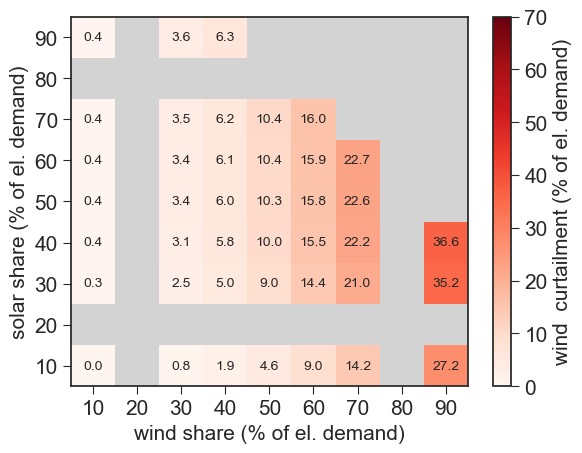

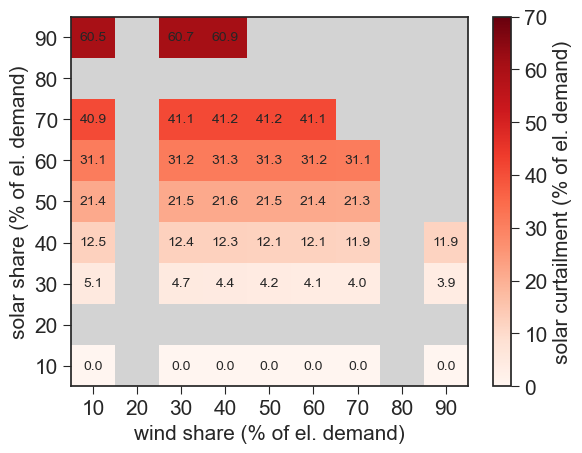

In [13]:
scens = [base_case]

variables = {"read":["wind absolute curt", 
                    "solar absolute curt",
                    "total demand"],
            "plot":["wind absolute curt",
                    "solar absolute curt"]}

df_base, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=True,
                              equidistant=True,
                              )

figs[base_case,0].savefig("figures/wind/model_wind_curtailment_base_case_demand.png",
                bbox_inches="tight",
                dpi=300)

figs[base_case,1].savefig("figures/solar/model_solar_curtailment_base_case_demand.png",
                bbox_inches="tight",
                dpi=300)

### Curtailment when including SDES

Optimum storage activity in PyPSA-Eur including energy losses:

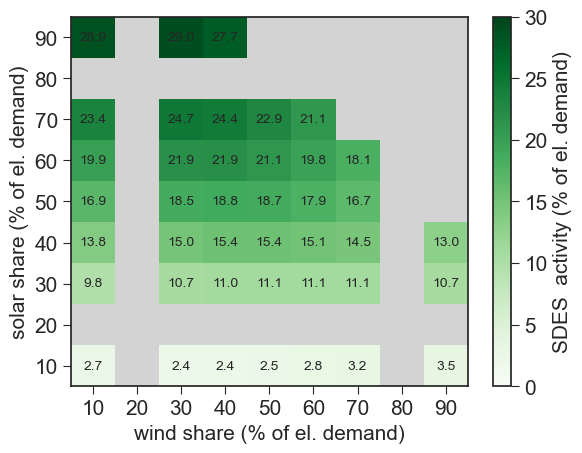

In [14]:
scens = [SDES_case]

variables = {"read":["SDES absolute dispatch","total demand"],
            "plot":["SDES absolute dispatch"]}

df_sdes_act, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=30,
                              var = "activity",
                              norm_w_demand=True,
                              equidistant=True,
                              )

figs[SDES_case,0].savefig("figures/solar/model_solar_SDES_activity.png",
                bbox_inches="tight",
                dpi=300)

Note that when including the impact of storage, the results obtained with the linear estimation in the above, we have assessed the impact at a fixed level of storage for all wind-solar combinations. Here, when comparing with the results from PyPSA-Eur, the storage level differ across all wind-solar combinations since the storage capacity and dispatch were optimized in every wind-solar combination.

Curtailment:

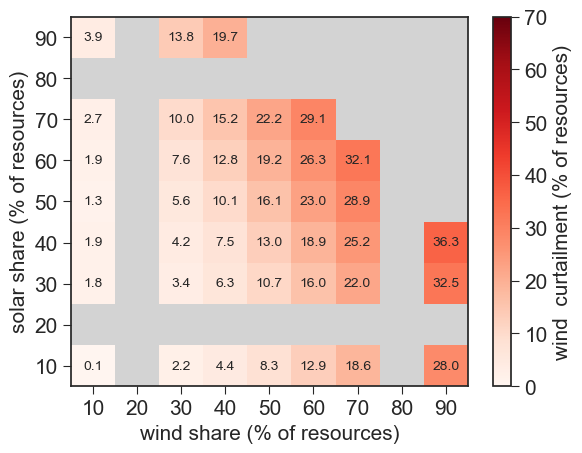

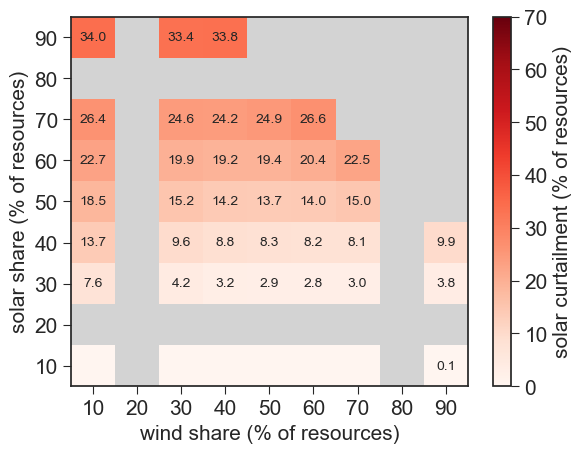

In [15]:
scens = [SDES_case]

variables = {"read":["wind curt", 
                    "solar curt",
                    "total demand",
                    "SDES absolute dispatch",
                     "SDES discharge cap"],
            "plot":["wind curt",
                    "solar curt"]}

df_sdes, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=False,
                              equidistant=True,
                              )

figs[SDES_case,0].savefig("figures/wind/model_wind_curtailment_SDES_case.png",
                bbox_inches="tight",
                dpi=300)

figs[SDES_case,1].savefig("figures/solar/model_solar_curtailment_SDES_case.png",
                bbox_inches="tight",
                dpi=300)

SDES relative impact on curtailment of solar PV resources:

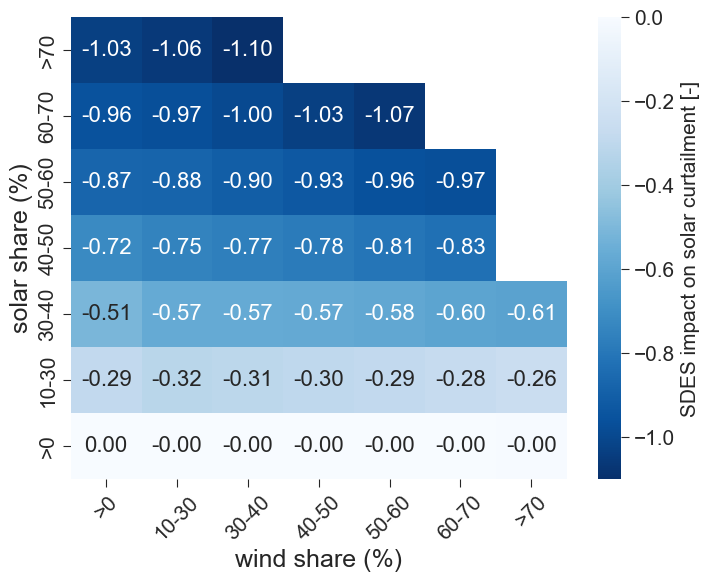

In [45]:
fig, ax, beta_sdes_s = plot_tech_impact("SDES","solar")
fig.savefig("figures/SDES_impact_solar.png",
                bbox_inches="tight",
                dpi=300)

SDES relative impact on wind curtailment:

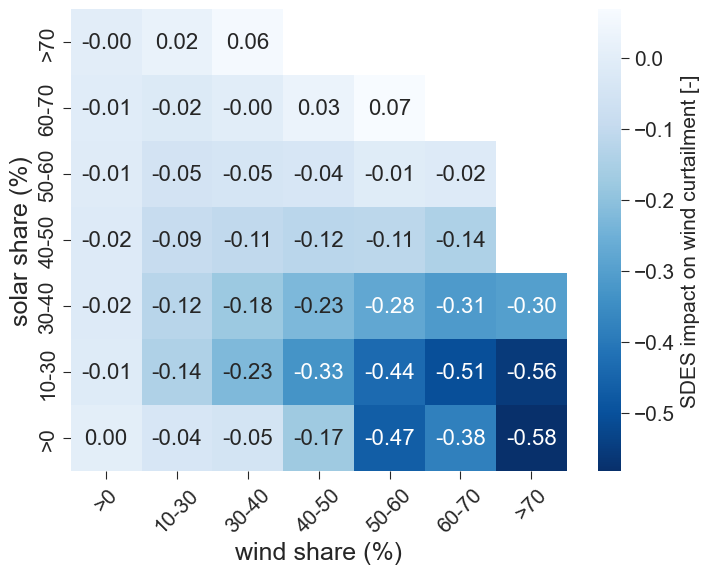

In [46]:
fig, ax, beta_sdes_w = plot_tech_impact("SDES","wind")
fig.savefig("figures/SDES_impact_wind.png",
                bbox_inches="tight",
                dpi=300)

### Curtailment when including LDES

Optimum storage activity in PyPSA-Eur including energy losses:

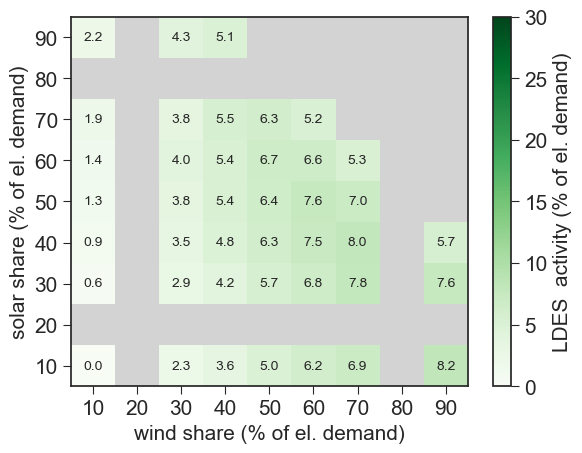

In [18]:
scens = [LDES_case]

variables = {"read":["LDES absolute dispatch","total demand"],
            "plot":["LDES absolute dispatch"]}

df_ldes_act, figs = mesh_color_2(scens,
                                variables,
                                RDIR,
                                vmin=0,
                                vmax=30,
                                var = "activity",
                                norm_w_demand=True,
                                equidistant=True,
                                )

figs[LDES_case,0].savefig("figures/wind/model_wind_LDES_activity.png",
                bbox_inches="tight",
                dpi=300)

Curtailment:

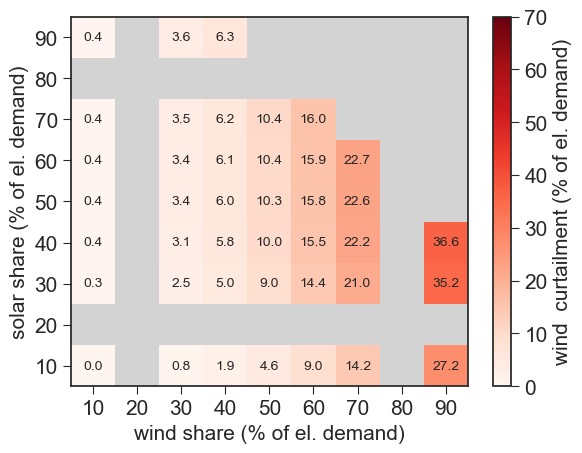

In [19]:
scens = [base_case]

variables = {"read":["wind absolute curt", 
                    "solar absolute curt",
                    "total demand"],
            "plot":["wind absolute curt",
                    # "solar absolute curt",
                    ]}

df_ldes, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=True,
                              equidistant=True,
                              )

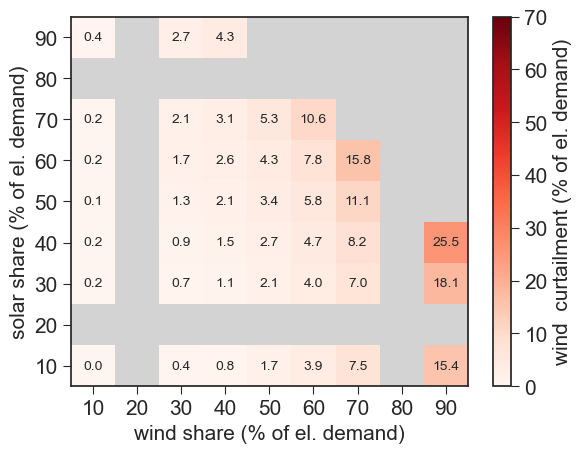

In [20]:
scens = [LDES_case]

variables = {"read":["wind absolute curt", 
                    "solar absolute curt",
                    "total demand"],
            "plot":["wind absolute curt",
                #     "solar absolute curt",
                    ]}

df_ldes, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=True,
                              equidistant=True,
                              )

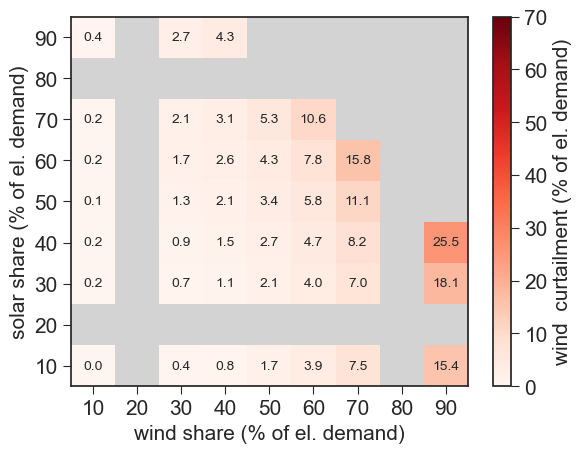

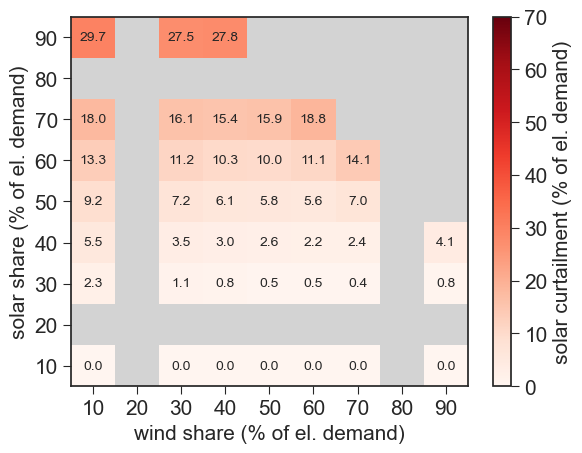

In [129]:
scens = [LDES_case]

variables = {"read":["wind absolute curt", 
                    "solar absolute curt",
                    "LDES absolute dispatch",
                    "LDES discharge cap",
                    "LDES energy cap",
                    "SDES absolute dispatch",
                    "SDES discharge cap",
                    "SDES energy cap",
                    "total demand"],
            "plot":["wind absolute curt",
                    "solar absolute curt",
                    ]}

df_ldes, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=True,
                              equidistant=True,
                              )

figs[LDES_case,0].savefig("figures/wind/model_wind_curtailment_LDES_case_" + curtailment_type + ".png",
                bbox_inches="tight",
                dpi=300)

Duration:

In [120]:
duration_sdes = df_ldes[LDES_case]["SDES energy cap"]*1e3/df_ldes[LDES_case]["SDES discharge cap"]
duration_ldes = df_ldes[LDES_case]["LDES energy cap"]*1e3/df_ldes[LDES_case]["LDES discharge cap"]

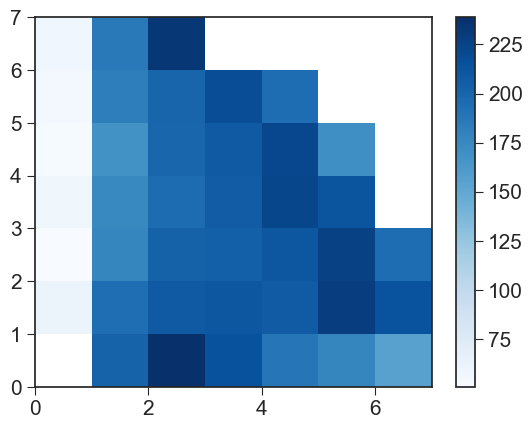

In [127]:
plt.pcolormesh(duration_ldes.unstack(),cmap="Blues")
plt.colorbar()

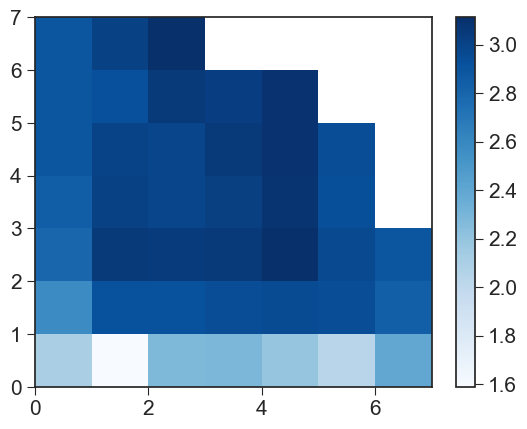

In [126]:
plt.pcolormesh(duration_sdes.unstack(),cmap="Blues")
plt.colorbar()

Capacity factor:

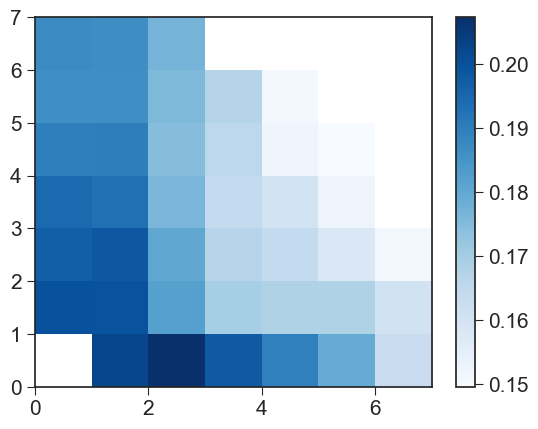

In [77]:
LDES_CF = (df_ldes[LDES_case]["LDES absolute dispatch"]/(df_ldes[LDES_case]["LDES discharge cap"]*1e3*8760)).unstack()
LDES_CF = LDES_CF.replace({np.inf:np.nan})

plt.pcolormesh(LDES_CF,cmap="Blues",vmin=LDES_CF.min().min(),vmax=LDES_CF.max().max())
plt.colorbar()

In [92]:
SDES_CF = (df_ldes[LDES_case]["SDES absolute dispatch"]/(df_ldes[LDES_case]["SDES discharge cap"]*0.97*1e3*8760)).unstack()
SDES_CF = SDES_CF.replace({np.inf:np.nan})

print("mean = ",SDES_CF.mean().mean())
print("min = ",SDES_CF.min().min())
print("max = ",SDES_CF.max().max())


mean =  0.09567804729611507
min =  0.06058245854947167
max =  0.10852141282645947


Relative contribution:

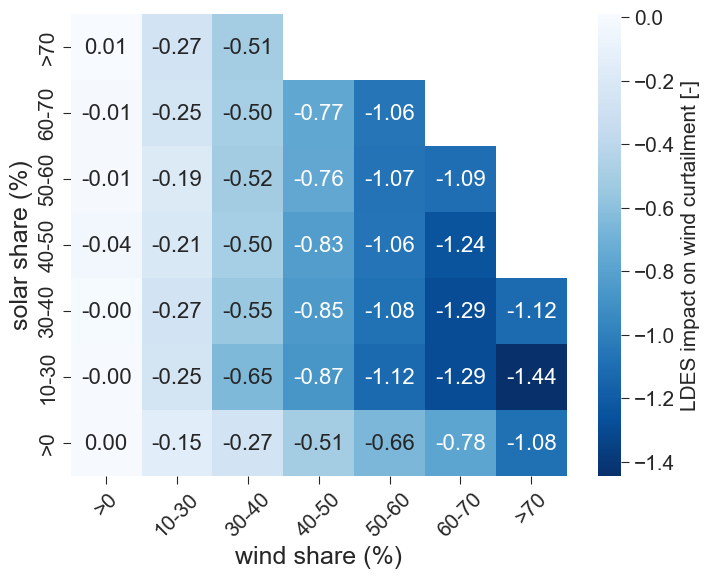

In [43]:
fig, ax, beta_ldes_w = plot_tech_impact("LDES","wind")

fig.savefig("figures/LDES_impact_wind.png",
                bbox_inches="tight",
                dpi=300)

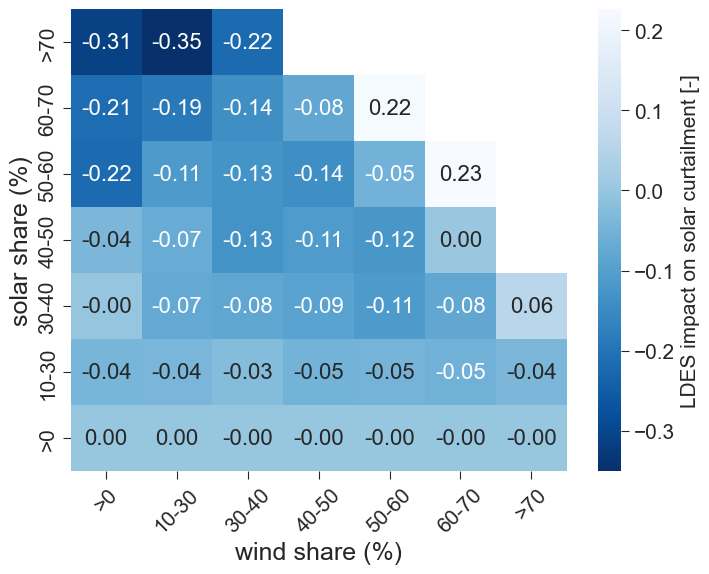

In [44]:
fig, ax, beta_ldes_s = plot_tech_impact("LDES","solar")

fig.savefig("figures/LDES_impact_solar.png",
                bbox_inches="tight",
                dpi=300)

### Curtailment when including transmission expansion

Optimum transmission expansion:

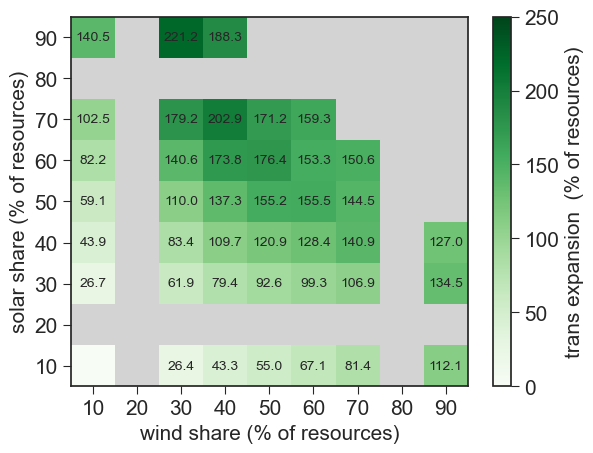

In [24]:
scens = [transmission_case]

variables = {"read":["transmission volume"],
            "plot":["transmission volume"]}

df_trans_act, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=250,
                              var = "expansion ",
                              norm_w_demand=False,
                              equidistant=True,
                              )

Curtailment:

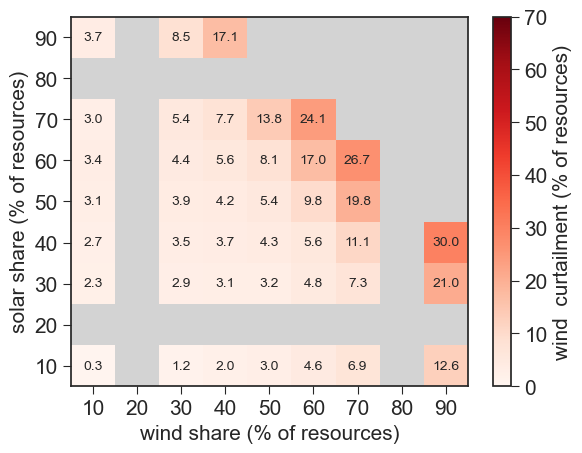

In [25]:
scens = [transmission_case]

variables = {"read":["wind curt", 
                    "total demand"],
            "plot":["wind curt",
                    ]}

df_trans, figs = mesh_color_2(scens,
                              variables,
                              RDIR,
                              vmin=0,
                              vmax=color_max_value,
                              norm_w_demand=False,
                              equidistant=True,
                              )